# Лабораторная работа 10, снижение размерности. Фида А.Д 6135

В качестве данных для этой работы был выбран датасет для классификации мобильных устройств по ценовому сегменту (файл train из предоставляемого набора): https://www.kaggle.com/iabhishekofficial/mobile-price-classification

Признаками является количество ядер, характеристики экрана, батареи и т.д.

20 признаков, целевой столбец. Всего в используемом файле 2000 строк.

Целевой вектор содержит четыре значения: 0 - низкая стоимость, 1 - средняя, 2 - высокая, 3 - очень высокая.

In [15]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns

### 0. Датасет

In [3]:
df = pd.read_csv('data/mobile_price_train.csv')
df.head()

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  
3        1             0     0            2  
4        1             1     0            1  

[5 rows x 21 columns]

In [4]:
y = df['price_range']
X = df.drop(columns=['price_range'])

### 1. Визуализация с TSNE

In [5]:
tsne = TSNE(n_components=2, perplexity=35, n_iter=300)
tsne_results = tsne.fit_transform(X)

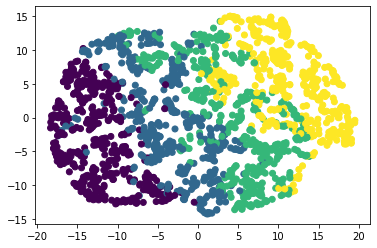

In [6]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y)

### 2. Визуализация с PCA

In [7]:
components = PCA(n_components=2).fit_transform(X)

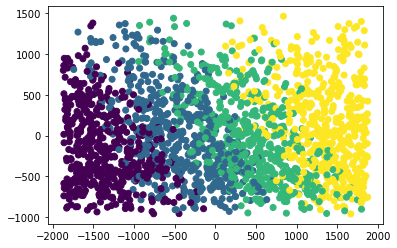

In [8]:
plt.scatter(components[:, 0], components[:, 1], c=y)

### 3. Отбор главных компонент по суммарному уровню объясненной дисперсии

In [9]:
components_ratio = PCA().fit(X).explained_variance_ratio_*100

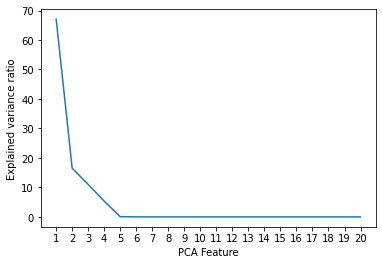

In [10]:
plt.plot(range(1, 21), components_ratio)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1, 21));

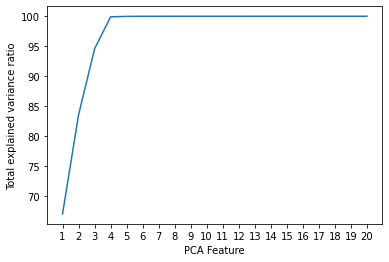

In [11]:
plt.plot(range(1, 21), np.cumsum(components_ratio))
plt.xlabel('PCA Feature')
plt.ylabel('Total explained variance ratio')
plt.xticks(range(1, 21));

In [12]:
for i in range(20):
    print('Первые {} компонент сохраняют {:.8}% дисперсии исходных данных'.format(i+1, np.sum(components_ratio[:i+1])))

Первые 1 компонент сохраняют 67.043941% дисперсии исходных данных
Первые 2 компонент сохраняют 83.561854% дисперсии исходных данных
Первые 3 компонент сохраняют 94.568014% дисперсии исходных данных
Первые 4 компонент сохраняют 99.90251% дисперсии исходных данных
Первые 5 компонент сохраняют 99.973938% дисперсии исходных данных
Первые 6 компонент сохраняют 99.992646% дисперсии исходных данных
Первые 7 компонент сохраняют 99.995313% дисперсии исходных данных
Первые 8 компонент сохраняют 99.997018% дисперсии исходных данных
Первые 9 компонент сохраняют 99.998575% дисперсии исходных данных
Первые 10 компонент сохраняют 99.999096% дисперсии исходных данных
Первые 11 компонент сохраняют 99.99958% дисперсии исходных данных
Первые 12 компонент сохраняют 99.999876% дисперсии исходных данных
Первые 13 компонент сохраняют 99.999914% дисперсии исходных данных
Первые 14 компонент сохраняют 99.999934% дисперсии исходных данных
Первые 15 компонент сохраняют 99.999948% дисперсии исходных данных
Первые

### 4. Сравнение моделей на полном наборе признаков и на усечённом

In [31]:
from catboost import *
from catboost import datasets

from sklearn.metrics import classification_report

#### Полные данные

In [20]:
val_size = len(X) // 2

Xtrain = X[:val_size]
Ytrain = y[:val_size]

Xval = X[val_size:]
Yval = y[val_size:]

c:\users\aleksandr_fida\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


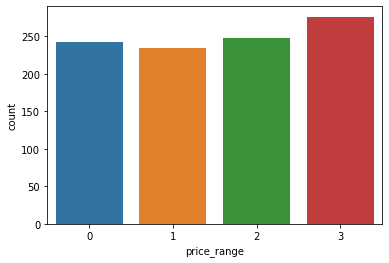

In [21]:
sns.countplot(Ytrain);

c:\users\aleksandr_fida\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


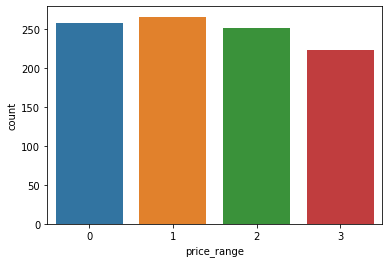

In [22]:
sns.countplot(Yval);

In [33]:
train_dataset = Pool(data=Xtrain,
                     label=Ytrain)

eval_dataset = Pool(data=Xval,
                    label=Yval)

model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')

In [34]:
model.fit(train_dataset)

preds_class = model.predict(eval_dataset)

preds_proba = model.predict_proba(eval_dataset)

preds_raw = model.predict(eval_dataset, 
                          prediction_type='RawFormulaVal')

0:	learn: 0.8633468	total: 1.04ms	remaining: 103ms
1:	learn: 0.6769878	total: 2.14ms	remaining: 105ms
2:	learn: 0.5851826	total: 3.3ms	remaining: 107ms
3:	learn: 0.5588518	total: 4.35ms	remaining: 104ms
4:	learn: 0.5394337	total: 5.52ms	remaining: 105ms
5:	learn: 0.5342352	total: 6.74ms	remaining: 106ms
6:	learn: 0.4812821	total: 7.89ms	remaining: 105ms
7:	learn: 0.4631313	total: 8.9ms	remaining: 102ms
8:	learn: 0.4233071	total: 9.81ms	remaining: 99.2ms
9:	learn: 0.3906482	total: 10.9ms	remaining: 97.7ms
10:	learn: 0.3849779	total: 11.8ms	remaining: 95.9ms
11:	learn: 0.3588360	total: 13ms	remaining: 95.2ms
12:	learn: 0.3366736	total: 14.4ms	remaining: 96.2ms
13:	learn: 0.3288695	total: 17.7ms	remaining: 109ms
14:	learn: 0.3213776	total: 18.9ms	remaining: 107ms
15:	learn: 0.3163393	total: 20.1ms	remaining: 106ms
16:	learn: 0.3143282	total: 21.1ms	remaining: 103ms
17:	learn: 0.3085274	total: 22.2ms	remaining: 101ms
18:	learn: 0.3024064	total: 23.3ms	remaining: 99.4ms
19:	learn: 0.2714556

In [35]:
print(classification_report(Yval, preds_class))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       258
           1       0.86      0.91      0.89       266
           2       0.87      0.84      0.85       252
           3       0.93      0.92      0.93       224

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



#### Данные с пониженной размерностью

In [36]:
pca = PCA(3)

pca_train = pca.fit_transform(Xtrain)
pca_val = pca.transform(Xval)

In [37]:
train_dataset = Pool(data=pca_train,
                     label=Ytrain)

eval_dataset = Pool(data=pca_val,
                    label=Yval)

model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')

In [38]:
model.fit(train_dataset)

preds_class = model.predict(eval_dataset)

preds_proba = model.predict_proba(eval_dataset)

preds_raw = model.predict(eval_dataset, 
                          prediction_type='RawFormulaVal')

0:	learn: 0.8661161	total: 950us	remaining: 94.1ms
1:	learn: 0.6888628	total: 1.95ms	remaining: 95.3ms
2:	learn: 0.5728720	total: 2.75ms	remaining: 88.8ms
3:	learn: 0.4894318	total: 3.63ms	remaining: 87.2ms
4:	learn: 0.4627020	total: 4.43ms	remaining: 84.2ms
5:	learn: 0.4448860	total: 5.22ms	remaining: 81.7ms
6:	learn: 0.3882342	total: 6.09ms	remaining: 80.9ms
7:	learn: 0.3600736	total: 6.97ms	remaining: 80.1ms
8:	learn: 0.3322070	total: 7.87ms	remaining: 79.6ms
9:	learn: 0.3076215	total: 8.69ms	remaining: 78.2ms
10:	learn: 0.2990321	total: 9.52ms	remaining: 77ms
11:	learn: 0.2946334	total: 10.3ms	remaining: 75.8ms
12:	learn: 0.2884881	total: 11.2ms	remaining: 74.7ms
13:	learn: 0.2713270	total: 12.1ms	remaining: 74.1ms
14:	learn: 0.2688585	total: 12.9ms	remaining: 73.2ms
15:	learn: 0.2567608	total: 13.8ms	remaining: 72.5ms
16:	learn: 0.2473607	total: 14.8ms	remaining: 72.3ms
17:	learn: 0.2448144	total: 16ms	remaining: 73ms
18:	learn: 0.2312566	total: 17ms	remaining: 72.7ms
19:	learn: 0

In [39]:
print(classification_report(Yval, preds_class))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       258
           1       0.88      0.94      0.91       266
           2       0.91      0.88      0.89       252
           3       0.95      0.93      0.94       224

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



### Выводы

Модель работает лучше на данных с пониженной размерностью, f1 выше для всех классов, кроме 0.